<a href="https://colab.research.google.com/github/harvardnlp/pytorch-struct/blob/master/notebooks/CTC_with_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -qU git+https://github.com/harvardnlp/pytorch-struct
!pip install -qU git+https://github.com/harvardnlp/genbmm
!pip install -q matplotlib

In [0]:
import torch
import torch_struct
import matplotlib.pyplot as plt

In [0]:
# Character Vocab, P is a padding token
vocab = ["a", "b", "c", "d", "e", "_", "P"]
v_dict = { a:i for i, a in enumerate(vocab)}
L = len(vocab)

# Char sequence
letters = [["a", "_", "b", "_", "c", "_", "d", "_", "e"], 
           ["a", "_", "b", "_", "c", "P", "P", "P", "P"]]
#letters = [["a", "_", "b", "_", "c"]]

t = len(letters[0])

# Padding

# Frame sequence
frames = [["a", "a", "a", "_", "b", "b", "c", "c", "c", "c", "_", "_", "d", "e"], 
          ["a", "a", "a", "a", "a", "_", "b", "b", "c", "c", "c", "c", "P", "P"]] 
#frames = [["a", "a", "a", "a", "a", "_", "b", "b", "c", "c", "c", "c"]] 

# Constants
T, B = len(frames[0]), len(frames)
D1, MATCH, D2 = 0, 1, 2

batch_lengths = [(t, T), (t-4, T-2)]
#batch_lengths = [(t, T)]

def show(m, ex):
    plt.yticks(torch.arange(len(letters[ex])), letters[ex])
    plt.xticks(torch.arange(T), [str(frames[ex][x.item()]) for x in torch.arange(T)])
    plt.imshow(m[ex].cpu().detach())

In [0]:
# Gold alignment. 
gold = torch.zeros(B, t).long()
for b in range(B):
    for i, l in enumerate(letters[0]):
        gold[b, i] = v_dict[l]
gold = gold[:, None, :].expand(B, T, t)

# Inputs (boost true frames a bit)
logits = torch.zeros(B, T, L)
for b in range(B):
    for i in range(T):
        logits[b, i, v_dict[frames[b][i]]] += 1 

In [0]:
# Construct the alignment problem from CTC

# Log-Potentials
log_potentials = torch.zeros(B, T, t, 3).fill_(-1e5)

# Match gold to logits. 
match = torch.gather(logits, 2, gold)

# CTC Rules:
for b, (lb, la)  in zip(range(B), batch_lengths):
    # la and lb are the sizes of the two (without padding)

    # Never allowed to fully skip regular characters (little t)
    log_potentials[b, :la, :lb:2,  D2] = -1e5

    # Free to skip _ characters (little t)
    log_potentials[b, :la, 1:lb:2, D2] = 0

    # First match with character is the logit. 
    log_potentials[b, :la, :lb, MATCH] = match[b, :la, :lb]

    # Additional match with character is the logit.
    log_potentials[b, :la, :lb, D1] = match[b, :la, :lb]

    # Match padding in an L shape
    log_potentials[b, la:, lb-1, D1] = 0
    log_potentials[b, -1, lb:, D2] = 0


log_potentials = log_potentials.transpose(1, 2).cuda()

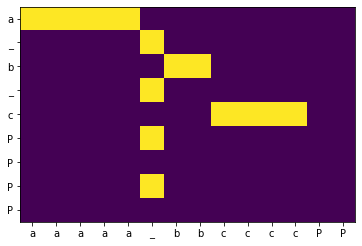

In [0]:
# Show input scores
show(match.transpose(1,2).exp(), 1)

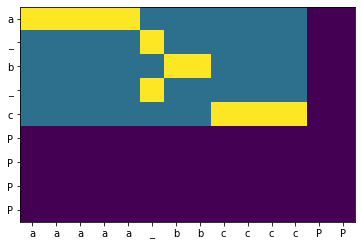

In [0]:
show(log_potentials[:, :, :, 1].exp(), 1)

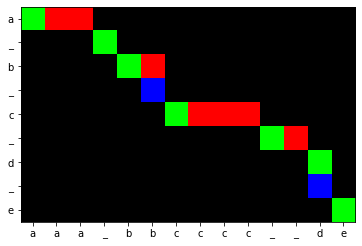

In [0]:
# Find best alignment
dist = torch_struct.AlignmentCRF(log_potentials)
show(dist.argmax, 0)


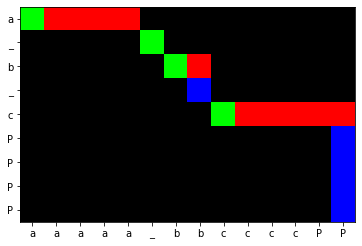

In [0]:
show(dist.argmax, 1)

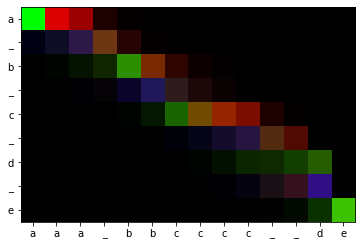

In [0]:
# Find marginals (see uncertainty from randomness)
show(dist.marginals, 0)

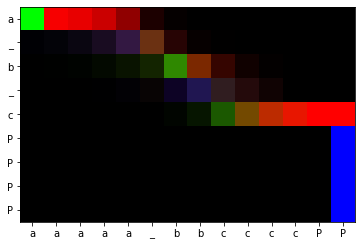

In [0]:
# No uncertainty for the padding.
show(dist.marginals, 1)

In [0]:
# Print the log sum exp of the data (for training)
print(dist.partition)

tensor([19.6766, 15.4172], device='cuda:0', grad_fn=<SqueezeBackward1>)
